In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import joblib
import torch.optim as optim
from training_utils import train_and_get_losses, plot_learning_curve
from math import sqrt

In [55]:
df = pd.read_csv("../data/cleaned_data.csv")
scaler = joblib.load("scalers/minmax.save")

## Splitting data, converting to tensors

In [56]:
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

X = df.drop('price', axis=1).values 
y = df['price'].values # Price is the target column 

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

/tmp/ipykernel_14043/1842155850.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_14043/1842155850.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


## Defining model architecture

In [77]:
## This came out to be the best out of all 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.leaky_relu1 = nn.LeakyReLU(0.01)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.leaky_relu2 = nn.LeakyReLU(0.01)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.fc3(x)
        return x

## Initializing the model

In [90]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1  

model = NeuralNetwork(input_size, hidden_size, output_size)

## Hyperparameters

In [91]:
# After experimenting with different architectures and hyperparameters, these seem to work the best
learning_rate = 0.004
criterion = nn.MSELoss() 
l2_lambda = 0.001 # L2 regulatization applied
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda) 

num_epochs = 100
batch_size = 128

# Keeping track of losses for plotting
train_losses = [] 
test_losses = []  

## Training loop + eval

Epoch [1/100], Training Loss: 1913123.5898347255, Test Loss: 151245264.0
Epoch [11/100], Training Loss: 241764.65079082994, Test Loss: 33358958.0
Epoch [21/100], Training Loss: 148469.62490373792, Test Loss: 22531932.0
Epoch [31/100], Training Loss: 103473.17424915585, Test Loss: 18128152.0
Epoch [41/100], Training Loss: 84333.11906877554, Test Loss: 16323035.0
Epoch [51/100], Training Loss: 75333.65296783365, Test Loss: 15489912.0
Epoch [61/100], Training Loss: 69756.6835347432, Test Loss: 15031688.0
Epoch [71/100], Training Loss: 66012.35596232451, Test Loss: 14745671.0
Epoch [81/100], Training Loss: 63095.16500799716, Test Loss: 14559233.0
Epoch [91/100], Training Loss: 60572.443960665834, Test Loss: 14440334.0
Train RMSE : 241.8821873061082, Test RMSE : 3779.6539524141626
Minimal test loss : 14209211.0 at epoch [98/100]


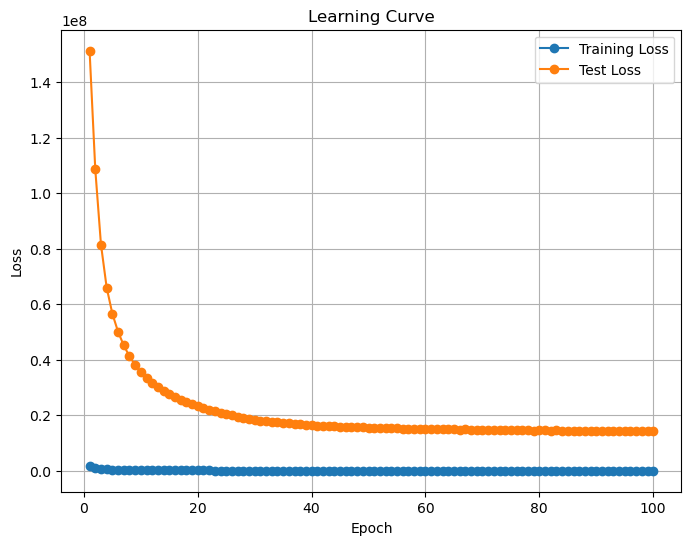

In [92]:
# To prevent overfitting, keeping track of test error,
# to see if it is minimal at final epoch, if not, decrease num_epochs
min_test_rmse = (10**8, None) # (loss, epoch)


for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()  
        outputs = model(batch_X)  
        loss = criterion(outputs, batch_y.view(-1, 1)) 

        loss.backward()  
        optimizer.step() 

        epoch_loss += loss.item()


    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        loss = criterion(test_outputs, y_test.view(-1, 1))
        model.train()

    if loss.item() < min_test_rmse[0]: min_test_rmse = (loss.item(), epoch) 
        
    train_losses.append(epoch_loss / len(X_train))
    test_losses.append(loss.item())
    
    if epoch%10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

print(f"Train RMSE : {sqrt(train_losses[-1])}, Test RMSE : {sqrt(test_losses[-1])}")
print(f"Minimal test loss : {min_test_rmse[0]} at epoch [{min_test_rmse[1]+1}/{num_epochs}]")

plot_learning_curve(train_losses, test_losses)


## Testing different epoch + learning rate + batch size combinations

In [5]:
epochs = [10*k for k in range(1,11)]
lr_vals = [0.1, 0.001, 0.2, 0.002, 0.3, 0.003, 0.4, 0.004]
batch_vals = [32, 64, 100, 128, 200, 256]
res_rmse = {}

In [7]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1  

for lr in lr_vals:
    for batch in batch_vals:
        for epoch in epochs:
            model = NeuralNetwork(input_size, hidden_size, output_size)
            res = train_and_get_losses(lr, batch, epoch, model, X_train, X_test, y_train, y_test)
            res_rmse[(lr,batch,epoch)] = res[1][-1]


Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=32
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=64
Starting training : lr=0.1, batch=100
Starting training : lr=0.1, batch=100
Starting training : lr=0.1, batch=100
Starting training : lr=0.1, batch=100
Starting training : lr=0.1, batch=100
Starting training : lr=0.1, batch=100
Starting training : lr=0.1, batc

Starting training : lr=0.002, batch=128
Starting training : lr=0.002, batch=128
Starting training : lr=0.002, batch=128
Starting training : lr=0.002, batch=128
Starting training : lr=0.002, batch=128
Starting training : lr=0.002, batch=128
Starting training : lr=0.002, batch=128
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=200
Starting training : lr=0.002, batch=256
Starting training : lr=0.002, batch=256
Starting training : lr=0.002, batch=256
Starting training : lr=0.002, batch=256
Starting training : lr=0.002, batch=256
Starting training : lr=0.002, batch=256
Starting training : lr=0.002, batch=256
Starting training : lr=0.002, batch=256


Starting training : lr=0.004, batch=32
Starting training : lr=0.004, batch=32
Starting training : lr=0.004, batch=32
Starting training : lr=0.004, batch=32
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=64
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=100
Starting training : lr=0.004, batch=128
Starting train

In [8]:
for comb in res_rmse:
    res_rmse[comb] = sqrt(res_rmse[comb])

In [9]:
## Sorting to get best performing (learning rate, batch size, num_epochs) combinations
sorted_dict = dict(sorted(res_rmse.items(), key=lambda item: item[1]))

In [10]:
sorted_dict ## (0.004, 128, 90) 

{(0.004, 128, 90): 3728.943684208706,
 (0.1, 64, 90): 3736.9110238270323,
 (0.001, 32, 100): 3782.752172691201,
 (0.2, 200, 80): 3788.2238582216864,
 (0.004, 128, 80): 3793.4626662193473,
 (0.004, 100, 70): 3795.0366269642245,
 (0.001, 32, 70): 3795.390757221185,
 (0.003, 128, 100): 3796.0479449026984,
 (0.002, 128, 90): 3797.6965386928955,
 (0.001, 32, 90): 3802.1501811475046,
 (0.002, 100, 100): 3804.4157238661496,
 (0.002, 64, 100): 3805.500229930357,
 (0.1, 64, 80): 3809.4248909776393,
 (0.004, 128, 70): 3812.1371958522163,
 (0.002, 32, 50): 3812.3571448645785,
 (0.003, 32, 40): 3812.6195718954177,
 (0.4, 128, 100): 3819.258043128272,
 (0.003, 100, 80): 3819.3377698234544,
 (0.003, 64, 50): 3820.7547683671087,
 (0.002, 128, 80): 3821.8782031875376,
 (0.001, 64, 90): 3824.866402895662,
 (0.002, 32, 70): 3825.7778294093346,
 (0.002, 128, 100): 3827.1017754953946,
 (0.002, 64, 80): 3827.5251795383397,
 (0.004, 32, 30): 3828.8700683099705,
 (0.003, 200, 100): 3829.415229509592,
 (0.003

## Saving weights

In [93]:
torch.save(model.state_dict(), '../weights/model.0.0.3.pth')